In [139]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ds_toolbox.modelling.time_series_utils as ts
import ds_toolbox.modelling.misc_utils as ds
from ds_toolbox.visualisation import corrplot

from sklearn.metrics import matthews_corrcoef

In [119]:
df = pd.read_csv("1976-2016-president.csv")

In [120]:
states = df.state.unique()

In [121]:
df["share"] = df.candidatevotes / df.totalvotes

In [122]:
small = df[["year", "state", "party", "share", "candidatevotes", "totalvotes"]]

small = small[small.party.isin(["democrat", "republican"])]

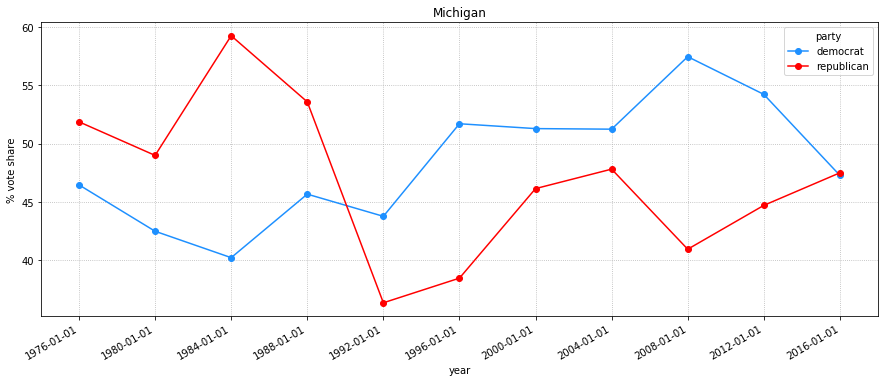

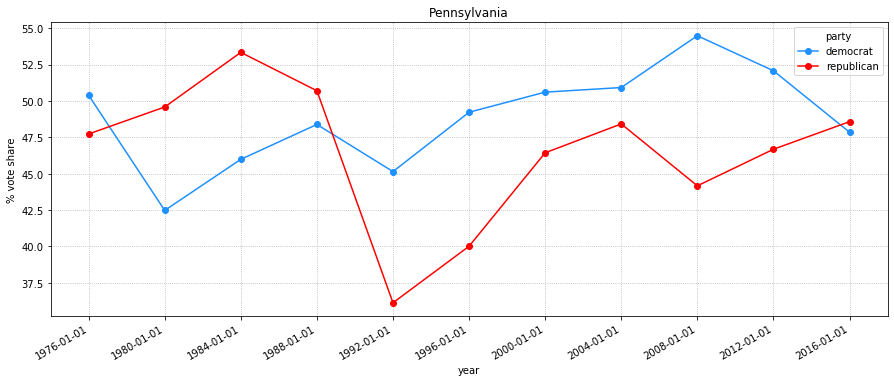

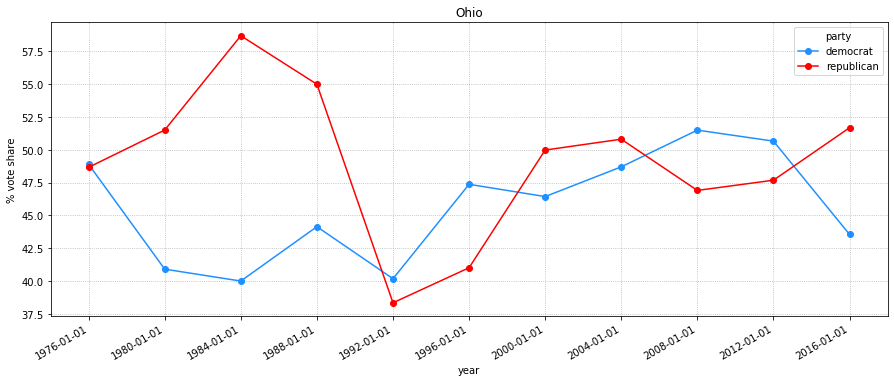

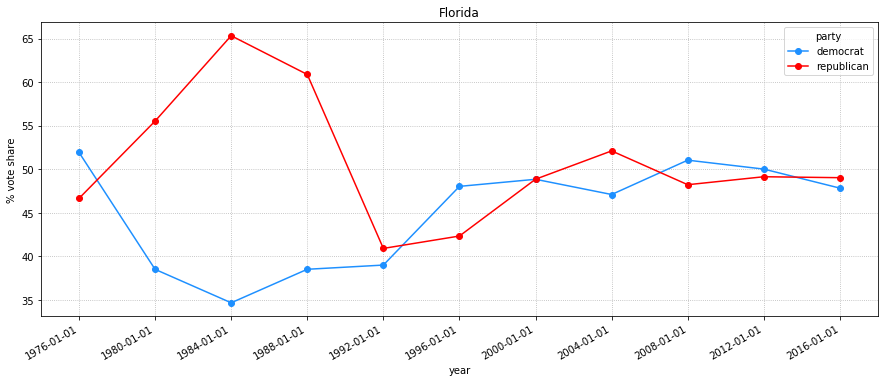

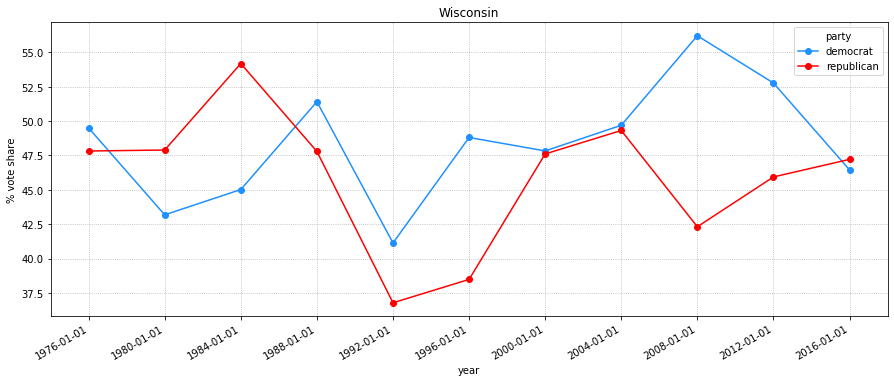

In [167]:
party_colors = ["dodgerblue", "red"]
battlegrounds = ["Michigan", "Pennsylvania", "Ohio", "Florida", "Wisconsin"]

for state in battlegrounds:
    ts.plot(state_shares[state], color=party_colors, tick_freq="4Y")
    plt.ylabel("% vote share")
    plt.title(state);

### check 2016 errors explicitly

In [126]:
for state in states:
    check_state = small[(small.year == 2016) & (small.state == state)]
    if len(check_state) != 2:
        print(state)
# 

Arizona
Maryland


In [124]:
# small[(small.year == 2016) & (small.state == "Maryland")]

In [127]:
# drop these erroneous rows explicitly
small = small.drop(index=[3542, 3543, 3414])

In [128]:
state_shares = small.pivot_table(index="year", columns=["state", "party"])["share"]

In [129]:
state_shares.index = pd.to_datetime(state_shares.index, format="%Y")
state_shares = 100 * state_shares

In [163]:
state_shares.to_csv("data/processed/state_shares.csv")

In [131]:
# state_shares.loc["2016", "Arizona"]

## Which states are most correlated with national?

In [132]:
# overall results since 1976
nationals = np.array(["D", "R", "R", "R", "D", "D", "R", "R", "D", "D", "R"])

In [133]:
to_string = {True : "D", False: "R"}
state_winners = pd.DataFrame(index=state_shares.index, columns=states)

for state in states:
    state_ts = state_shares[state]
    
    bool_mask = state_ts.democrat > state_ts.republican
    winner = bool_mask.map(to_string)
    
    result_label = state_ts.assign(winner=winner.values)
    state_winners[state] = result_label["winner"]
    
state_winners["national"] = nationals

In [134]:
to_bool = {v: k for k, v in to_string.items()}

In [135]:
bellweather_factor = pd.Series(index=states, name="bellweather_factor", dtype=float)

for state in states:
    matches_national_result = state_winners[[state, "national"]].nunique(axis=1) == 1
    matching_fraction = matches_national_result.sum() / len(state_winners)
    bellweather_factor[state] = matching_fraction

In [136]:
# which states have called the most elections correctly?
bellweather_factor.sort_values(ascending=False) * 11

Ohio                    11.0
Florida                 10.0
Missouri                 9.0
Arkansas                 9.0
Nevada                   9.0
Louisiana                9.0
Tennessee                9.0
Kentucky                 9.0
Pennsylvania             9.0
Iowa                     8.0
Maryland                 8.0
New Hampshire            8.0
New Mexico               8.0
North Carolina           8.0
Wisconsin                8.0
Michigan                 8.0
Delaware                 8.0
Colorado                 8.0
Illinois                 7.0
Georgia                  7.0
Connecticut              7.0
Maine                    7.0
California               7.0
Arizona                  7.0
Massachusetts            7.0
Indiana                  7.0
Alabama                  7.0
South Carolina           7.0
Montana                  7.0
New Jersey               7.0
West Virginia            7.0
Virginia                 7.0
Vermont                  7.0
Texas                    7.0
Mississippi   

In [193]:
state_winners_binary = state_winners.apply(lambda x: x.map(to_bool))
state_correlations = state_winners_binary.corr(method=matthews_corrcoef)
state_correlations.drop(columns="national", inplace=True)

/Users/michael/environments/env_python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


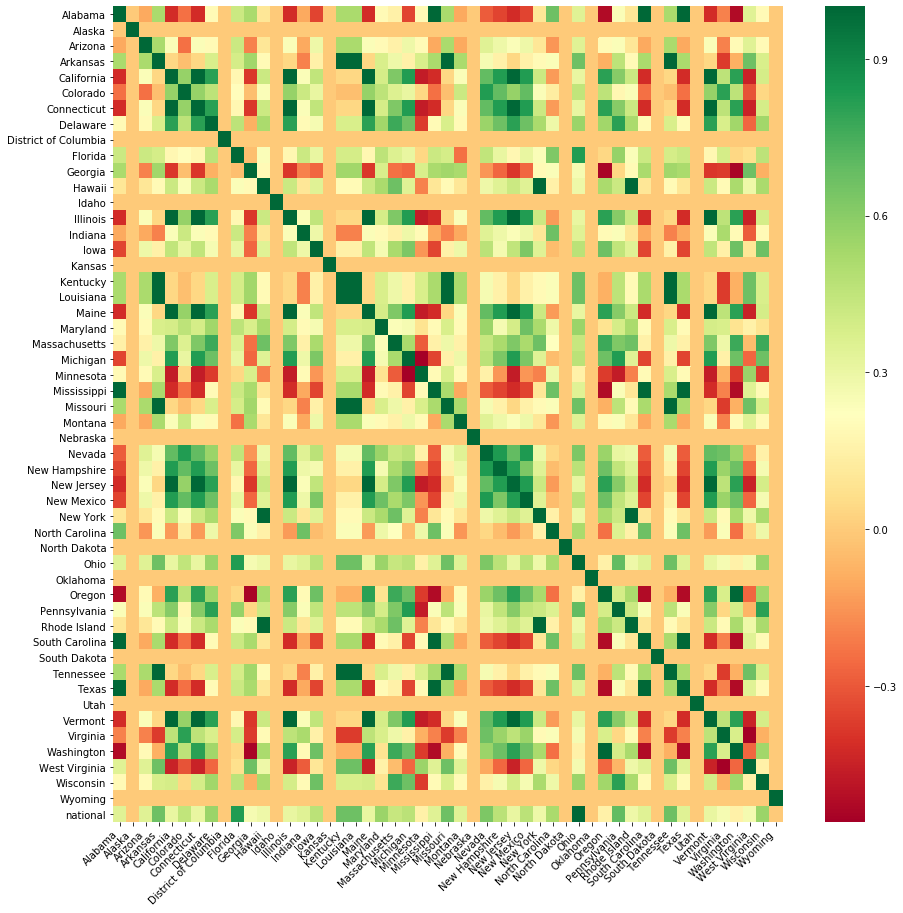

In [194]:
plt.figure(figsize=(15, 15))
sns.heatmap(state_correlations, cmap="RdYlGn")
plt.xticks(rotation=45, ha="right");

In [196]:
state_correlations["Ohio"].sort_values(ascending=False)

national                1.000000
Ohio                    1.000000
Florida                 0.828079
Pennsylvania            0.690066
Tennessee               0.670820
Arkansas                0.670820
Kentucky                0.670820
Louisiana               0.670820
Missouri                0.670820
Nevada                  0.633333
Wisconsin               0.559017
Delaware                0.559017
Maryland                0.559017
North Carolina          0.516398
Iowa                    0.466667
Michigan                0.466667
New Mexico              0.466667
New Hampshire           0.466667
Colorado                0.448543
Massachusetts           0.430331
Montana                 0.346410
Arizona                 0.346410
Indiana                 0.346410
Mississippi             0.346410
Texas                   0.346410
Alabama                 0.346410
South Carolina          0.346410
Maine                   0.310530
California              0.310530
Connecticut             0.310530
Vermont   

In [211]:
# corrplot(state_winners_binary, method=matthews_corrcoef)

## 2016 margins

How many states in 2016 were won by a margin of less than 10 points?

In [30]:
# state_shares.loc["2016", "Alabama"][0].democrat

In [143]:
margins_2016 = pd.Series(index=states, dtype=float)

for state in states:
    result_2016 = state_shares.loc["2016", state].iloc[0]
    margin = result_2016.republican - result_2016.democrat
    margins_2016.loc[state] = margin

In [144]:
sorted_vals = margins_2016.abs().sort_values(ascending=False)

In [145]:
(sorted_vals < 10).sum()

17

In [170]:
battlegrounds = sorted_vals[sorted_vals < 10].index
safe_states = sorted_vals[sorted_vals > 10].index


safe_2016 = margins_2016.loc[safe_states] 

In [171]:
safe_rep = safe_2016[safe_2016 > 0].index
safe_dem = safe_2016[safe_2016 < 0].index

In [172]:
sorted(list(battlegrounds))

['Arizona',
 'Colorado',
 'Florida',
 'Georgia',
 'Iowa',
 'Maine',
 'Michigan',
 'Minnesota',
 'Nevada',
 'New Hampshire',
 'New Mexico',
 'North Carolina',
 'Ohio',
 'Pennsylvania',
 'Texas',
 'Virginia',
 'Wisconsin']

In [209]:
# # https://stackoverflow.com/questions/16816013/is-it-possible-to-print-using-different-colors-in-ipythons-notebook
    
# from IPython.display import HTML as html_print

# def cstr(s, color='black'):
#     return f"<text style=color:{color}>{s}</text>"
# #     return "<text style=color:{}>{}</text>".format(color, s)

# left, word, right = 'foo' , 'abc' , 'bar'
# html_print(cstr(' '.join([left, cstr(word, color='red'), right]), color='black') )

In [175]:
margins_2016["Arizona"]

3.5455946276278354

In [176]:
len(safe_rep), len(safe_dem)

(20, 14)

In [177]:
len(battlegrounds)

17

## Electoral votes 

538 in total, but how many are realistically up for grabs?

In [181]:
# downloaded from https://state.1keydata.com/state-electoral-votes.php
votes_per_state = pd.read_csv("data/electoral_votes_per_state.csv", 
                              header=None, index_col=0, names=["votes"]).squeeze()


In [182]:
assert (margins_2016.index.sort_values() == votes_per_state.index.sort_values()).all()

In [183]:
n_safe_dem = votes_per_state.loc[safe_dem].sum()
n_safe_rep = votes_per_state.loc[safe_rep].sum()

In [184]:
n_safe_dem, n_safe_rep

(182, 126)

In [185]:
votes_per_state.sum() - n_safe_dem - n_safe_rep
# number of electoral votes up for grabs

230

In [189]:
votes_per_state.loc[battlegrounds].sort_values()

Maine              4
New Hampshire      4
New Mexico         5
Iowa               6
Nevada             6
Colorado           9
Wisconsin         10
Minnesota         10
Arizona           11
Virginia          13
North Carolina    15
Georgia           16
Michigan          16
Ohio              18
Pennsylvania      20
Florida           29
Texas             38
Name: votes, dtype: int64

## Which states had the narrowest margin in 2016?

## Which states had the biggest swing from 2012 to 2016?